# Projet 10 : Réalisez une application de recommandation de contenu

## Contexte

Vous êtes le CTO et cofondateur de la start-up My Content qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. Vous êtes en pleine construction d’un premier MVP (Minimum Viable Product) qui prendra la forme d’une application.

Dans un premier temps, votre start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers en utilisant des données disponibles en ligne puisque vous n'en avez pas encore.

Votre mission est de développer une première version de votre système de recommandation d'une sélection de cinq articles, sous forme d’Azure Functions, tout en prenant en compte l'ajout de nouveaux articles et utilisateurs.

Puis de réaliser une application simple de gestion du système de recommandation (interface d’affichage d’une liste d’id utilisateurs, d’appel Azure functions pour l’id choisi, et d’affichage des 5 articles recommandés)

## Contenu des données du jeu de données News Portal User Interactions by Globo.com :

Le jeu de données provient du portail d’actualité brésilien Globo. Il traite des clics utilisateurs/articles.

Il contient 3 fichiers et un dossier zip :
- clicks.zip : contient les données d’interaction utilisateur → article (clics, horodatage, etc.).

- clicks_sample.csv : contient un échantillon des données d’interaction utilisateur → article (clics, horodatage, etc.).

- articles_metadata.csv : les métadonnées des articles (titre, catégorie, etc.).

- articles_embeddings.pickle : embeddings pré-calculés des articles.


## Librairies utilisées avec le langage Python :

In [44]:
# Importation des librairies
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
import glob
import os
import warnings
warnings.filterwarnings('ignore')


## Données brutes :

### articles_metadata.csv

In [45]:
# Importation des données :
data_articles = pd.read_csv('C:/tutorial-env/OCR/Projet10/data/articles_metadata.csv',encoding='latin',delimiter=",")
data_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [46]:
data_articles.shape

(364047, 5)

In [47]:
data_articles.dtypes

article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

In [48]:
data_articles.duplicated().sum()

0

In [49]:
data_articles[['article_id','category_id','publisher_id']] = data_articles[['article_id','category_id','publisher_id']].astype(str)
data_articles[['article_id','category_id','publisher_id']].describe()

,article_id,category_id,publisher_id
count,364047,364047,364047
unique,364047,461,1
top,0,281,0
freq,1,12817,364047


Modifions le type des colonnes pour en savoir plus et pour pouvoir interpréter les dates de la colonne "created_at_ts"

In [50]:
data_articles['words_count'] = data_articles[['words_count']].astype(int)
data_articles['article_created_at'] = pd.to_datetime(data_articles['created_at_ts'], unit='ms')
data.describe()

,words_count,created_at
count,364047.000000,364047
mean,190.897727,2016-09-16 23:57:17.328421888
min,0.000000,2006-09-27 11:14:35
25%,159.000000,2015-10-15 16:00:43.500000
50%,186.000000,2017-03-13 16:27:29
75%,218.000000,2017-11-05 14:09:11
max,6690.000000,2018-03-13 12:12:30
std,59.502766,NaN


Le csv articles_metadata comprend 364047 articles avec des id uniques, sans doublons et sans valeurs manquantes.

Les articles appartiennent à l'une des 461 catégories.

La colonne "publisher_id" n'a qu'un seul id, elle n'est donc pas pertinente pour notre projet.

La nouvelle colonne "created_at" correspond à la date et heure de publication de l'article.

Le nombre moyen de mots par articles est de 190 mots avec un minimum de 0 et un maximum de 6690.

### clicks.csv

In [51]:
# Importation des données :
# Chercher tous les fichiers .csv du dossier
all_files = glob.glob(os.path.join("C:/tutorial-env/OCR/Projet10/data/clicks/", "*.csv"))

# Charger et concaténer tous les fichiers
dfs = []
for f in all_files:
    df = pd.read_csv(f,encoding='latin',delimiter=",")
    dfs.append(df)

clicks = pd.concat(dfs, ignore_index=True)
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [52]:
clicks.shape

(2988181, 12)

In [53]:
clicks.dtypes

user_id                object
session_id             object
session_start          object
session_size           object
click_article_id       object
click_timestamp        object
click_environment      object
click_deviceGroup      object
click_os               object
click_country          object
click_region           object
click_referrer_type    object
dtype: object

In [54]:
clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']] = clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']].astype(str)
clicks[['user_id','session_id','click_article_id','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type']].describe()

,user_id,session_id,click_article_id,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,46033,3,5,8,11,28,7
top,5890,1507563657895091,160974,4,1,17,1,25,2
freq,1232,124,37213,2904478,1823162,1738138,2852406,804985,1602601


In [55]:
clicks.duplicated().sum()

0

Modifions le type des colonnes pour en savoir plus et pour pouvoir interpréter les dates des colonnes "session_start" et "click_timestamp".

In [56]:
clicks['session_size'] = clicks[['session_size']].astype(int)
clicks['session_start'] = pd.to_datetime(clicks['session_start'], unit='ms')
clicks['click_timestamp'] = pd.to_datetime(clicks['click_timestamp'], unit='ms')
clicks.describe()

,session_start,session_size,click_timestamp
count,2988181,2.988181e+06,2988181
mean,2017-10-08 14:17:08.013157120,3.901885e+00,2017-10-08 14:51:05.606100224
min,2017-10-01 02:37:03,2.000000e+00,2017-10-01 03:00:00.026000
25%,2017-10-04 13:35:52,2.000000e+00,2017-10-04 14:20:52.854000128
50%,2017-10-08 20:09:00,3.000000e+00,2017-10-08 20:35:30.480999936
75%,2017-10-11 19:16:54,4.000000e+00,2017-10-11 19:43:24.600999936
max,2017-10-17 03:36:19,1.240000e+02,2017-11-13 20:04:14.886000
std,NaN,3.929941e+00,NaN


La fusion des différents csv clicks_hour comprend 2988181 lignes et 12 colonnes, sans doublons et sans valeurs manquantes.

Les données sont basées sur les 1048594 sessions de 322897 clients. Ils ont cliqués sur 46033 articles différents.

Les colonnes 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type' permettent de comprendre le contexte de l'utilisateur. Nous ne les utiliserons pas dans notre projet.

La colonne "session_start" correspond à la date et heure d'ouverture de la session.

La colonne "click_timestamp" correspond à la date et heure du clic.

Le nombre moyen de clics par session, portés par la colonne "session_size",  est de 3.9 clicls avec un minimum de 2 et un maximum de 124.

Créons notre dataframe final avec les variables qui nous intéressent :

In [57]:
# Renommer des colonnes pour la jointure
clicks = clicks.rename(columns={'click_article_id': 'article_id'})
data_articles = data_articles.rename(columns={'category_id': 'article_category_id'})
data_articles = data_articles.rename(columns={'words_count': 'article_words_count'})

In [59]:
# Ajout des colonnes à clicks
df = clicks.merge(data_articles[['article_id', 'article_category_id', 'article_words_count' ,	'article_created_at']],
    on='article_id', how='left')
df.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2,247,239,2017-09-30 15:11:56


In [60]:
# Suppression de colonnes non  pertinentes
df = df.drop(['click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'], axis=1)
df.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,281,280,2017-09-30 19:41:58
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,136,226,2017-10-01 00:08:02
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,375,159,2017-09-30 21:43:59
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,209,206,2017-09-30 16:13:45
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,247,239,2017-09-30 15:11:56


In [64]:
df.describe(include='all')

,user_id,session_id,session_start,session_size,article_id,click_timestamp,article_category_id,article_words_count,article_created_at
count,2988181,2988181,2988181,2.988181e+06,2988181,2988181,2988181,2.988181e+06,2988181
unique,322897,1048594,NaN,NaN,46033,NaN,316,NaN,NaN
top,5890,1507563657895091,NaN,NaN,160974,NaN,281,NaN,NaN
freq,1232,124,NaN,NaN,37213,NaN,370843,NaN,NaN
mean,NaN,NaN,2017-10-08 14:17:08.013157120,3.901885e+00,NaN,2017-10-08 14:51:05.606100224,NaN,2.086283e+02,2017-09-30 05:50:23.356218368
min,NaN,NaN,2017-10-01 02:37:03,2.000000e+00,NaN,2017-10-01 03:00:00.026000,NaN,0.000000e+00,2006-12-20 00:00:00
25%,NaN,NaN,2017-10-04 13:35:52,2.000000e+00,NaN,2017-10-04 14:20:52.854000128,NaN,1.730000e+02,2017-10-03 17:56:13
50%,NaN,NaN,2017-10-08 20:09:00,3.000000e+00,NaN,2017-10-08 20:35:30.480999936,NaN,1.980000e+02,2017-10-07 19:10:41
75%,NaN,NaN,2017-10-11 19:16:54,4.000000e+00,NaN,2017-10-11 19:43:24.600999936,NaN,2.320000e+02,2017-10-11 10:10:51
max,NaN,NaN,2017-10-17 03:36:19,1.240000e+02,NaN,2017-11-13 20:04:14.886000,NaN,6.690000e+03,2017-11-14 13:26:54


Il paraît étrange que les dates des sessions soient comprises entre le 01/10/2017 et le 17/10/2017 alors que certains clics ont une date jusqu'au 13/11/2017.

On peut considérer que les sessions ont une validité maximum de 24h et donc enlever les sessions qui ont des clics plus de 24h après le début de la session.

In [74]:
invalid2 = df[df['click_timestamp'] > df['session_start'] + pd.Timedelta(hours=24)]
print(f"Nb de clics trop loin après le début de la session : {len(invalid2)}")

Nb de clics trop loin après le début de la session : 7331



## Analyse exploratoire univariée :

Les variables catégorielles sont des identifiants qui ont trop de valeurs pour qu'elles soient pertinentes à analyser.

### Session_start

<Axes: title={'center': 'Volume de sessions par jour'}, xlabel='session_start'>

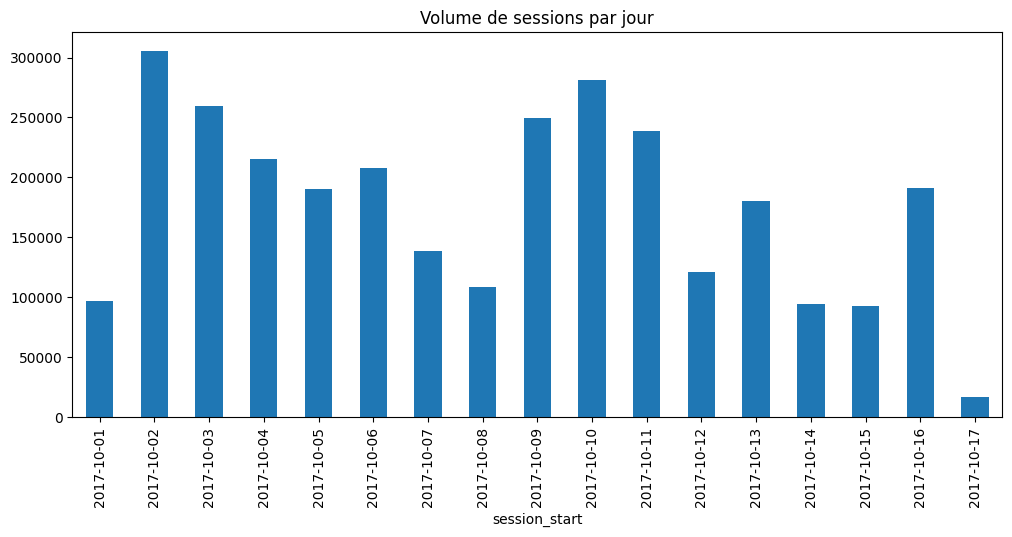

In [66]:
session_per_day = df['session_start'].dt.date.value_counts().sort_index()
session_per_day.plot(figsize=(12,5),kind='bar', title="Volume de sessions par jour")

<Axes: title={'center': 'Sessions par jour de la semaine'}, xlabel='session_start'>

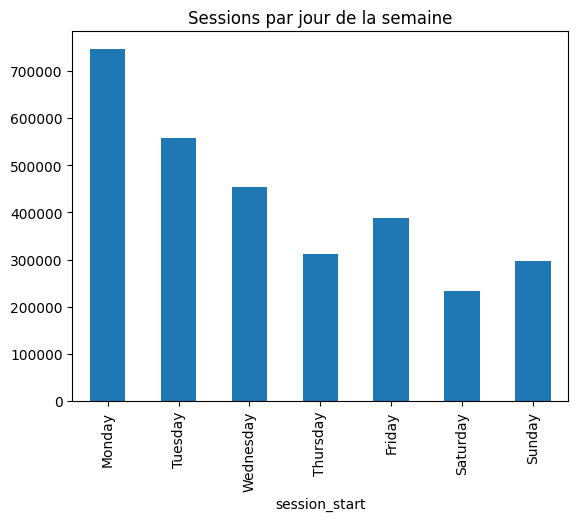

In [69]:
session_per_number_day = df['session_start'].dt.day_name()
session_per_number_day.value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).plot(kind='bar', title="Sessions par jour de la semaine")

<Axes: title={'center': 'Sessions par heure du jour'}, xlabel='session_start'>

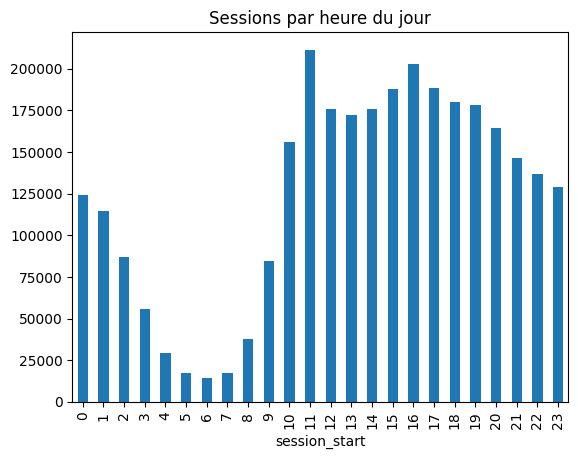

In [68]:
session_per_hour = df['session_start'].dt.hour
df['session_start'].dt.hour.value_counts().sort_index().plot(kind='bar', title="Sessions par heure du jour")

Nous avons les sessions des 17 premiers jours du mois d'octobre 2017. Le nombre de sessions par jour est plutôt fluctuant mais on peut voir qu'il y a moins de sessions ouvertes le week-end.

Il y a également moins d'ouverture de sessions entre 2 heures et 10 heures.

### Click_timestamp

<Axes: title={'center': 'Volume de clics par jour'}, xlabel='click_timestamp'>

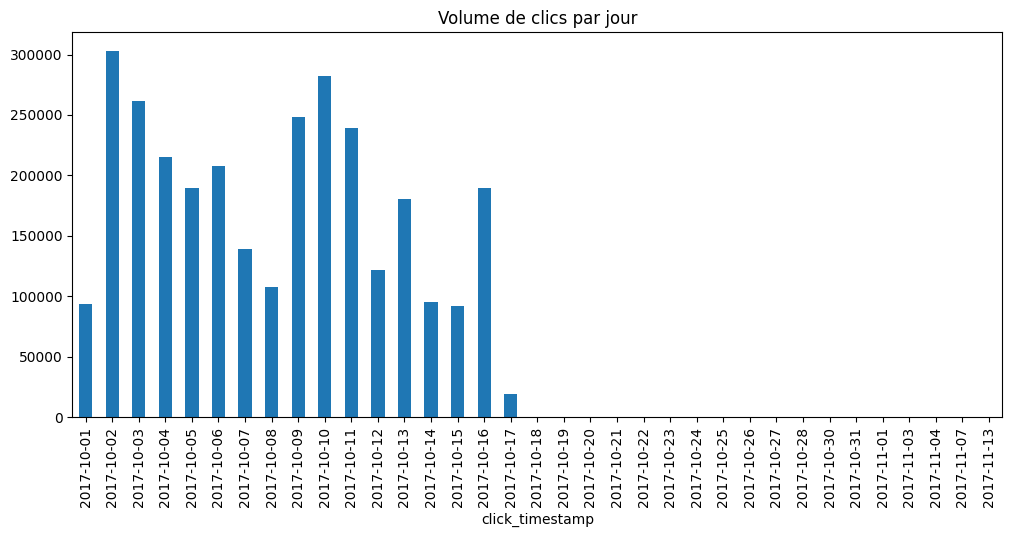

In [70]:
clic_per_day = df['click_timestamp'].dt.date.value_counts().sort_index()
clic_per_day.plot(figsize=(12,5),kind='bar', title="Volume de clics par jour")

In [72]:
clic_per_day = df['click_timestamp'].dt.date.value_counts().sort_index()
print(clic_per_day)

click_timestamp
2017-10-01     94056
2017-10-02    303177
2017-10-03    261159
2017-10-04    215415
2017-10-05    190003
2017-10-06    207646
2017-10-07    139323
2017-10-08    108110
2017-10-09    248208
2017-10-10    282391
2017-10-11    238969
2017-10-12    121467
2017-10-13    180723
2017-10-14     95216
2017-10-15     92163
2017-10-16    189779
2017-10-17     19664
2017-10-18       272
2017-10-19       125
2017-10-20       122
2017-10-21        23
2017-10-22        32
2017-10-23        40
2017-10-24        29
2017-10-25        18
2017-10-26        12
2017-10-27         7
2017-10-28         2
2017-10-30        12
2017-10-31         4
2017-11-01         6
2017-11-03         2
2017-11-04         2
2017-11-07         2
2017-11-13         2
Name: count, dtype: int64
